Paquetes necesarios

In [1]:
# --- Configuración inicial ---
import cv2, math, numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import pandas as pd
import csv
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


TAREA: Los ejemplos ilustrativos anteriores permiten saber el número de monedas presentes en la imagen. ¿Cómo saber la cantidad de dinero presente en ella? Sugerimos identificar de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras obtener esa información y las dimensiones en milímetros de las distintas monedas, realiza una propuesta para estimar la cantidad de dinero en la imagen. Muestra la cuenta de monedas y dinero sobre la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. 

Una vez resuelto el reto con la imagen ideal proporcionada, captura una o varias imágenes con monedas. Aplica el mismo esquema, tras identificar la moneda del valor determinado, calcula el dinero presente en la imagen. ¿Funciona correctamente? ¿Se observan problemas?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo. 



C:\Users\User\AppData\Local\Temp\ipykernel_14756\1270441574.py:20: RuntimeWarning: overflow encountered in scalar subtract
  dist = math.hypot(x - cx, y - cy)


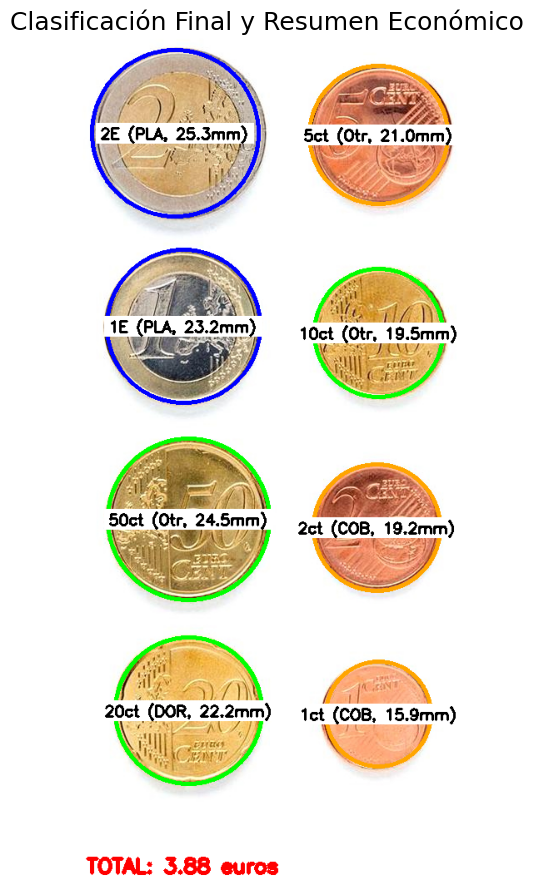

In [2]:
# Radios reales de las monedas en mm
real_radii = {
    1: 16.25,
    2: 18.75,
    5: 21.25,
    10: 19.75,
    20: 22.25,
    50: 24.25,
    100: 23.25,
    200: 25.75,
}

# Función para manejar clics del ratón dentro de un círculo detectado previamente, y marcarlo como moneda de 1 euro y referencia
def click_event(event, x, y, flags, param):
    global moneda_1euro
    if event == cv2.EVENT_LBUTTONDOWN:
        if circs is not None:
            for idx, i in enumerate(circs[0, :]):
                cx, cy, r = i
                dist = math.hypot(x - cx, y - cy)
                if dist <= r:
                    moneda_1euro = (cx, cy, r)
                    cv2.circle(img_gris_cont, (cx, cy), r, (255, 0, 0), 3)
                    cv2.putText(img_gris_cont, "1 Euro", (cx - 40, cy - r - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
                    cv2.imshow("Selecciona una moneda", img_gris_cont)
                    cv2.waitKey(500)
                    cv2.destroyAllWindows()
                    return

# Función para analizar el color RGB promedio en un parche alrededor de un punto
def analizar_color_rgb(px, py, tamaño_parche=5):
    alto, ancho = img.shape[:2]
    mitad = tamaño_parche // 2
    x1 = max(px - mitad, 0)
    x2 = min(px + mitad + 1, ancho)
    y1 = max(py - mitad, 0)
    y2 = min(py + mitad + 1, alto)
    parche = img[y1:y2, x1:x2]
    mean_color = np.mean(parche, axis=(0, 1))
    R, G, B = mean_color[2], mean_color[1], mean_color[0]
    if ((G - B > 30) and (G - B < 50)) and ((R - G > 70) and (R - G < 90)):
        return "COBRIZO"
    elif ((G - B > 60) and (G - B < 90)) and ((R - G > 30) and (R - G < 50)):
        return "DORADO"
    elif ((abs(R - G) > 0) and (abs(R - G) < 30)) and ((abs(R - B) > 0) and (abs(R - B) < 30)):
        return "PLATEADO"
    else:
        return "Otro"

# Procesado de la imagen
img = cv2.imread('Monedas.jpg')
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
pimg = cv2.medianBlur(img_gris, 5)

# Detección de círculos usando la Transformada de Hough y selección de la moneda de 1 euro
circs = cv2.HoughCircles(pimg, cv2.HOUGH_GRADIENT, 1, 100, param1=100, param2=50, minRadius=10, maxRadius=150)
img_gris_cont = cv2.cvtColor(pimg, cv2.COLOR_GRAY2BGR)
circles_radii = {}
if circs is not None:
    circs = np.uint16(np.around(circs))
    for idx, i in enumerate(circs[0, :], start=1):
        x, y, r = i
        circles_radii[idx] = r

moneda_1euro = None
cv2.namedWindow("Selecciona una moneda", cv2.WINDOW_NORMAL)
cv2.imshow("Selecciona una moneda", img)
cv2.setMouseCallback("Selecciona una moneda", click_event)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Clasificación de monedas por tamaño
clasificaciones_monedas_tamaño = []
for idx, r in circles_radii.items():
    cx, cy, _ = circs[0, idx - 1]
    radio_mm = r / moneda_1euro[2] * real_radii[100]
    diferencias = [(valor, abs(radio_mm - real_r)) for valor, real_r in real_radii.items()]
    diferencias.sort(key=lambda x: x[1])
    monedas_cercanas = [diferencias[0][0], diferencias[1][0]]
    clasificaciones_monedas_tamaño.append((idx, monedas_cercanas))

# Alasificación de monedas por color
tamaño_parche_inicial = 5
tamaño_parche_aumentado = 10
color_por_moneda = {}
for idx, i in enumerate(circs[0, :], start=1):
    cx, cy, r = i
    cx_int, cy_int = int(cx), int(cy)
    px = int(cx + 0.9 * r)
    py = int(cy)
    centro_color = analizar_color_rgb(cx_int, cy_int, tamaño_parche_inicial)
    borde_color = analizar_color_rgb(px, py, tamaño_parche_inicial)
    if centro_color == borde_color:
        color_final = centro_color
    elif "PLATEADO" in (centro_color, borde_color):
        color_final = "PLATEADO"
    else:
        centro_color = analizar_color_rgb(cx_int, cy_int, tamaño_parche_aumentado)
        borde_color = analizar_color_rgb(px, py, tamaño_parche_aumentado)
        if centro_color == borde_color:
            color_final = centro_color
        elif "PLATEADO" in (centro_color, borde_color):
            color_final = "PLATEADO"
        else:
            color_final = centro_color
    color_por_moneda[idx] = color_final

grupo_cobrizas = [1, 2, 5]
grupo_doradas = [10, 20, 50]
grupo_plateadas = [100, 200]

# Clasificación final combinando tamaño y color
clasificacion_final = []
for idx, monedas_candidatas in clasificaciones_monedas_tamaño:
    posibles_por_tamaño = monedas_candidatas
    color_detectado = color_por_moneda.get(idx, "Otro")
    if color_detectado == "COBRIZO":
        grupo_color = grupo_cobrizas
    elif color_detectado == "DORADO":
        grupo_color = grupo_doradas
    elif color_detectado == "PLATEADO":
        grupo_color = grupo_plateadas
    else:
        grupo_color = []
    candidatos_color = [v for v in posibles_por_tamaño if v in grupo_color]
    if candidatos_color:
        if len(candidatos_color) == 1:
            valor_final = candidatos_color[0]
        else:
            cx, cy, r_px = circs[0, idx - 1]
            radio_mm = r_px / moneda_1euro[2] * real_radii[100]
            valor_final = min(candidatos_color, key=lambda v: abs(real_radii[v] - radio_mm))
    else:
        valor_final = posibles_por_tamaño[0]
    clasificacion_final.append((idx, valor_final, color_detectado))

# Resumen económico y visualización final
conteo_monedas = {valor: 0 for valor in real_radii.keys()}
valor_total = 0
for _, valor, _ in clasificacion_final:
    conteo_monedas[valor] += 1
    valor_total += valor

euros = valor_total // 100
centimos = valor_total % 100
total_texto = f"TOTAL: {euros}.{centimos} euros"

img_final = img.copy()

if circs is not None:
    for idx, valor, color in clasificacion_final:
        cx, cy, r = circs[0, idx - 1]
        if moneda_1euro is not None:
            radio_mm_aprox = r / moneda_1euro[2] * real_radii[100]
        else:
            radio_mm_aprox = 0
        etiqueta = f"{valor//100}E" if valor >= 100 else f"{valor}ct"
        texto = f"{etiqueta} ({color[:3]}, {radio_mm_aprox:.1f}mm)"
        if valor >= 100:
            border_color = (255, 0, 0)
        elif valor >= 10:
            border_color = (0, 255, 0)
        else:
            border_color = (0, 165, 255)
        cv2.circle(img_final, (int(cx), int(cy)), int(r), border_color, 3)
        font = cv2.FONT_HERSHEY_SIMPLEX
        scale = 0.6
        thickness = 2
        text_size = cv2.getTextSize(texto, font, scale, thickness)[0]
        text_x = int(cx - text_size[0] / 2)
        text_y = int(cy + text_size[1] / 2)
        cv2.rectangle(img_final, (text_x - 5, text_y - text_size[1] - 5),
                      (text_x + text_size[0] + 5, text_y + 5), (255, 255, 255), -1)
        cv2.putText(img_final, texto, (text_x, text_y), font, scale, (0, 0, 0), thickness)

alto_original, ancho_original, _ = img_final.shape
altura_extra = 80
img_con_resumen = np.zeros((alto_original + altura_extra, ancho_original, 3), dtype=np.uint8)
img_con_resumen[0:alto_original, 0:ancho_original] = img_final
img_con_resumen[alto_original:alto_original + altura_extra, 0:ancho_original] = 255

font = cv2.FONT_HERSHEY_SIMPLEX
scale = 0.8
thickness = 2
cv2.putText(img_con_resumen, total_texto, (20, alto_original + 65), font, scale, (0, 0, 255), thickness + 1)

plt.figure(figsize=(18, 11))
plt.imshow(cv2.cvtColor(img_con_resumen, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Clasificación Final y Resumen Económico", fontsize=18)
plt.show()


TAREA: La tarea consiste en extraer características (geométricas y/o visuales) de las tres imágenes completas de partida, y *aprender* patrones que permitan identificar las partículas en nuevas imágenes. Para ello se proporciona como imagen de test *MPs_test.jpg* y sus correpondientes anotaciones *MPs_test_bbs.csv* con la que deben obtener las métricas para su propuesta de clasificación de microplásticos, además de la matriz de confusión. La matriz de confusión permitirá mostrar para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente como perteneciente a una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

[fragment-03-olympus-10-01-2020.JPG] Contornos válidos: 71


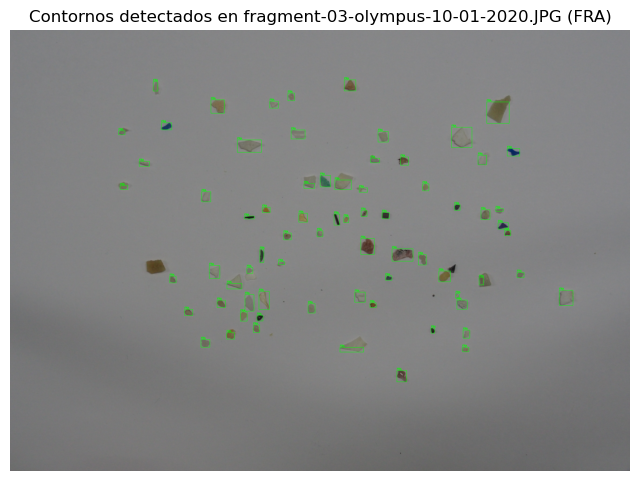

[pellet-03-olympus-10-01-2020.JPG] Contornos válidos: 55


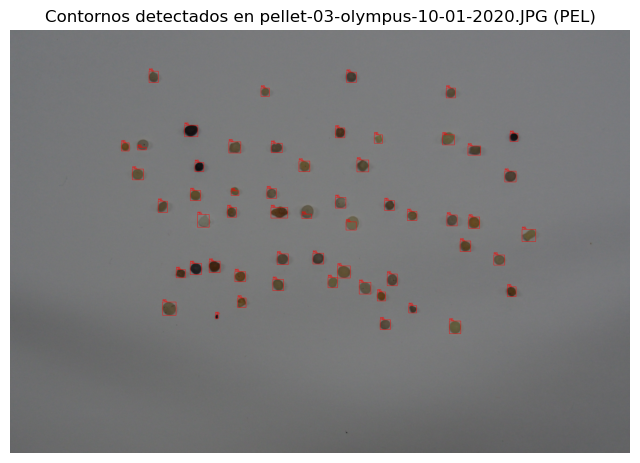

[tar-03-olympus-10-01-2020.JPG] Contornos válidos: 54


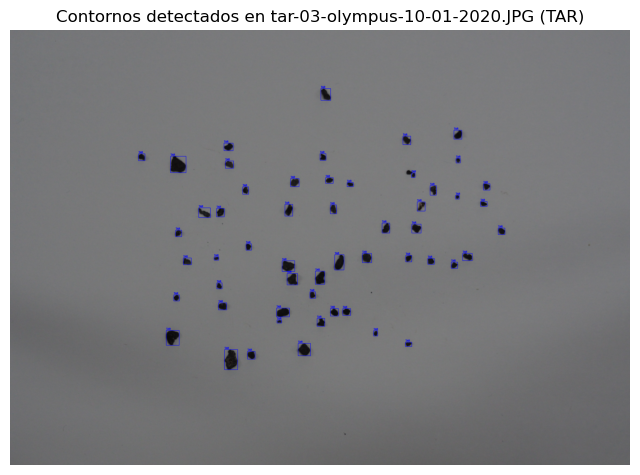

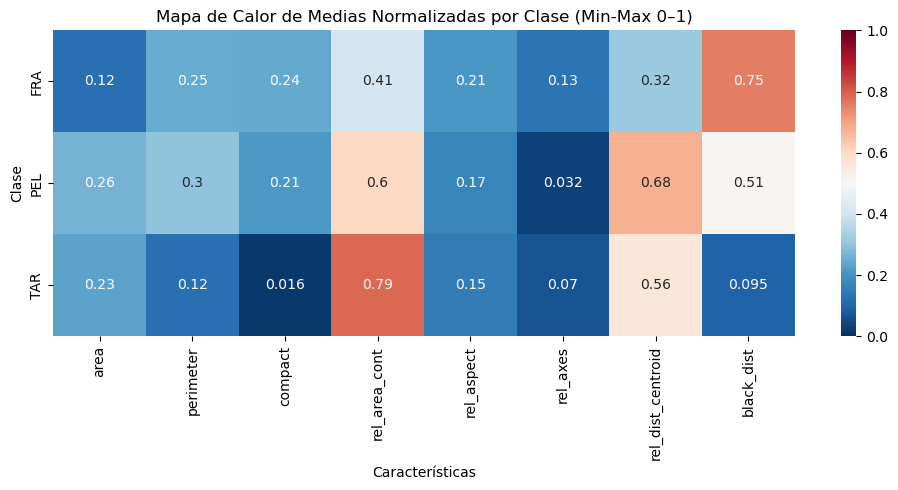

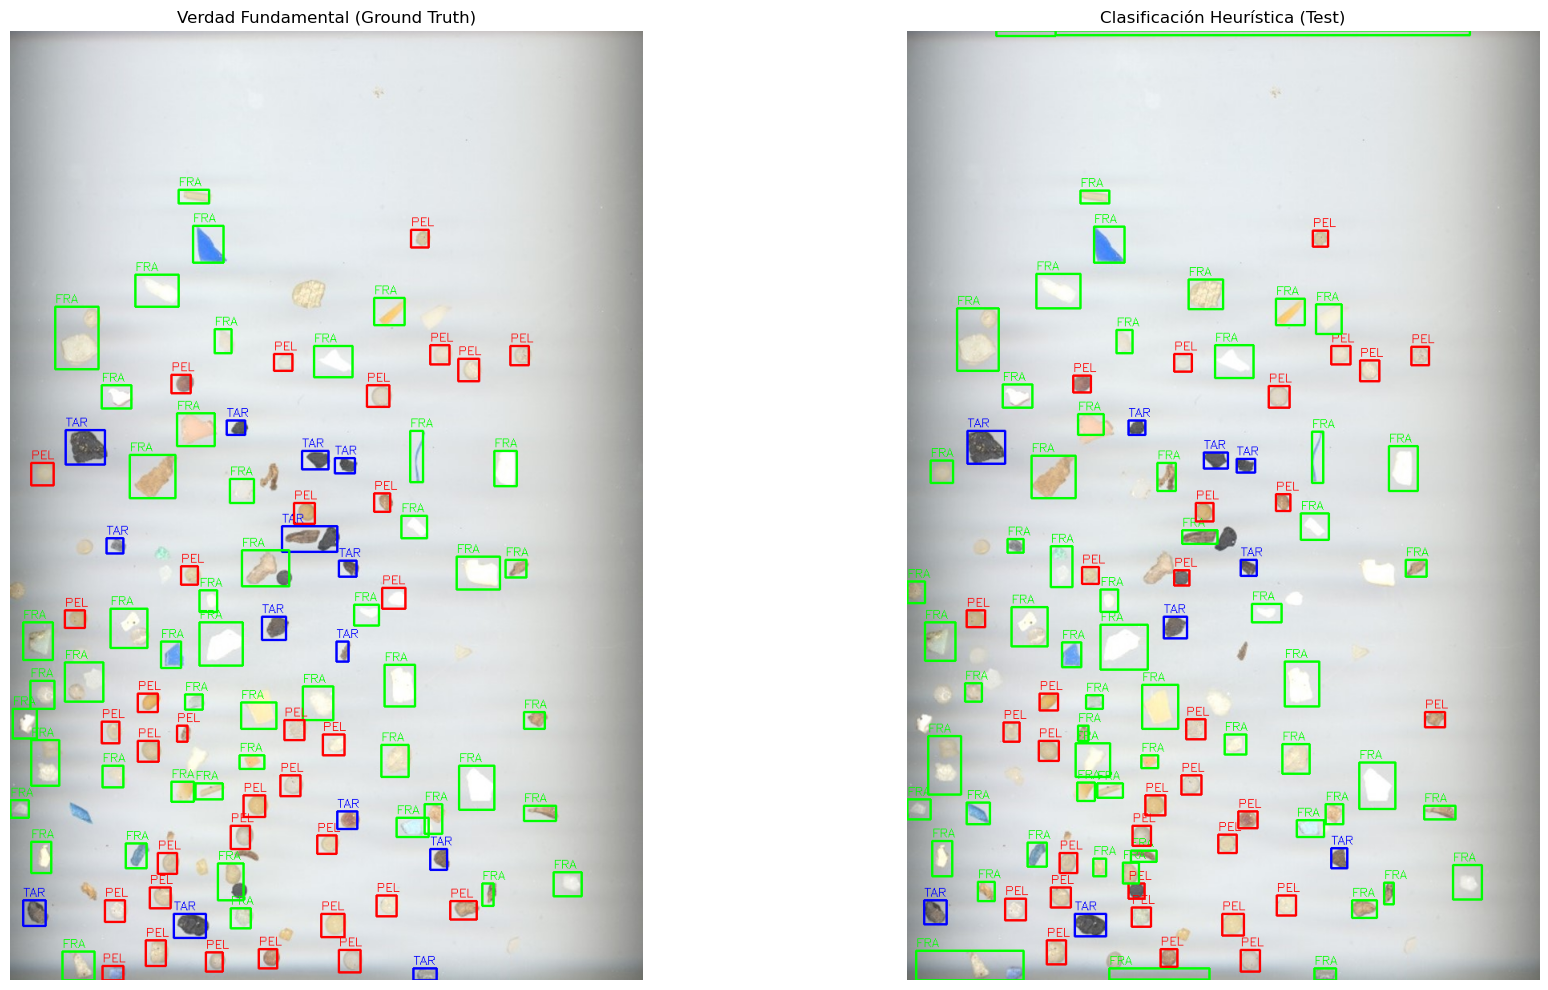


--- MÉTRICAS ---
Precisión Global (Accuracy): 0.8933
Precisión Macro (Precision): 0.9204
Sensibilidad Macro (Recall): 0.8631
Puntuación F1 Macro (F1-score): 0.8852


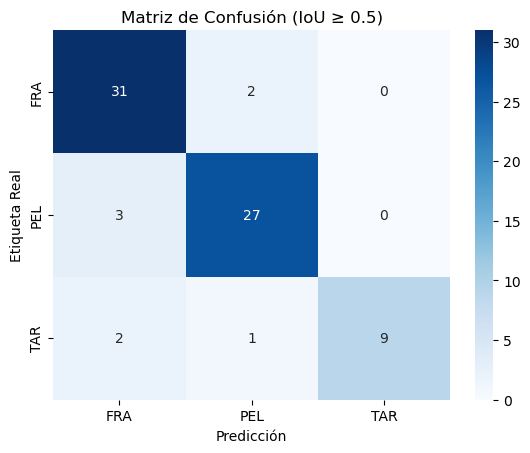

In [3]:
# Pesos de las características analizadas
feature_weights = {
    "area": 3.5,
    "perimeter": 1.0,
    "compact": 4.5,
    "rel_area_cont": 2.5,
    "rel_aspect": 3.5,
    "rel_axes": 4.0,
    "rel_dist_centroid": 5.5,
    "black_dist": 3.5,
}

# Colores que representan cada clase
colors_bgr = {'FRA': (0,255,0), 'PEL': (0,0,255), 'TAR': (255,0,0)}
classes = sorted(list(colors_bgr.keys()))

# Detección de contornos válidos (dentro de un rango de área y sin solapamiento significativo)
def detect_valid_contours(img, min_area=300, max_area=10000, minimal_overlap=True):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    background = cv2.medianBlur(gray, 31)
    gray_corrected = cv2.addWeighted(gray, 1.5, background, -0.5, 0)
    mask = cv2.adaptiveThreshold(cv2.GaussianBlur(gray_corrected,(5,5),0), 255,
                                 cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = [c for c in contours if min_area <= cv2.contourArea(c) <= max_area]

    # Remove overlapping contours
    valid = []
    for c in contours:
        keep = True
        x, y, w, h = cv2.boundingRect(c)
        for c2 in valid:
            x2, y2, w2, h2 = cv2.boundingRect(c2)
            inter_w = max(0, min(x+w, x2+w2) - max(x, x2))
            inter_h = max(0, min(y+h, y2+h2) - max(y, y2))
            inter_area = inter_w * inter_h
            if inter_area > 0 and minimal_overlap:
                keep = False
                break
        if keep:
            valid.append(c)
    return valid

# Extracción de características de los contornos detectados
def extract_contour_features(img, contours):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    features, rects = [], []

    for c in contours:
        area = cv2.contourArea(c)
        if area == 0:
            continue
        perimeter = cv2.arcLength(c, True)
        x, y, w, h = cv2.boundingRect(c)
        rel_aspect = w/h if h else 0
        rel_area_cont = area/(w*h) if w*h else 0
        compact = (perimeter**2)/(4*np.pi*area)
        rel_axes = 0
        if len(c) >= 5:
            try:
                (xc, yc), (MA, ma), ang = cv2.fitEllipse(c)
                rel_axes = ma/MA if MA else 0
            except:
                rel_axes = 0
        M = cv2.moments(c)
        cx, cy = (int(M["m10"]/M["m00"]), int(M["m01"]/M["m00"])) if M["m00"] else (0,0)
        dists = [np.linalg.norm(np.array([cx,cy]) - pt[0]) for pt in c]
        rel_dist_centroid = min(dists)/max(dists) if dists and max(dists)!=0 else 0
        mask_obj = np.zeros(gray.shape, np.uint8)
        cv2.drawContours(mask_obj, [c], -1, 255, -1)
        mean_color = cv2.mean(img, mask=mask_obj)[:3]
        black_dist = np.linalg.norm(np.array(mean_color) - np.array([0,0,0]))

        features.append([
            area, perimeter, compact, rel_area_cont,
            rel_aspect, rel_axes, rel_dist_centroid, black_dist
        ])
        rects.append((x, y, w, h))
    return np.array(features), rects

# Procesamiento de imagen
def process_image(img_file, min_area=300, max_area=10000):
    img = cv2.imread(img_file)
    if img is None:
        print(f"Error: No se pudo cargar {img_file}")
        return None, None
    contours = detect_valid_contours(img, min_area, max_area)
    features, rects = extract_contour_features(img, contours)
    print(f"[{img_file}] Contornos válidos: {len(contours)}")
    return features, rects, img, contours

# Clasificación ponderada y normalizada
def weighted_normalized_classify(x, features_train_norm, mu, sigma, weights):
    x_norm = (x - mu) / sigma
    w_values = np.array(list(weights.values()))
    dist = {}
    for cls, samples in features_train_norm.items():
        # Distancia euclidiana ponderada al cuadrado (Mahalanobis modificada)
        dists = [np.sqrt(np.sum((x_norm - v)**2 * w_values**2)) for v in samples]
        dist[cls] = np.mean(dists)
    return min(dist, key=dist.get)

# Extracción de anotaciones desde CSV
def get_annotations(csv_file):
    annotations = []
    with open(csv_file, newline="") as file:
        reader = csv.DictReader(file)
        for row in reader:
            x_min, y_min, x_max, y_max = map(int, [row["x_min"], row["y_min"], row["x_max"], row["y_max"]])
            annotations.append({"label": row["label"], "rect": (x_min, y_min, x_max-x_min, y_max-y_min)})
    return annotations

# Imágenes de entrenamiento
train_images = {
    'FRA': 'fragment-03-olympus-10-01-2020.JPG',
    'PEL': 'pellet-03-olympus-10-01-2020.JPG',
    'TAR': 'tar-03-olympus-10-01-2020.JPG'
}

# Características extraídas del entrenamiento y visualización de los fragmentos detectados
features_train = {}
for cls, f in train_images.items():
    feats, rects, img_viz, contours = process_image(f)
    if feats is not None:
        features_train[cls] = feats
        img_draw = img_viz.copy()
        for rect in rects:
            x, y, w, h = rect
            color = colors_bgr.get(cls, (128,128,128))
            cv2.rectangle(img_draw, (x, y), (x+w, y+h), color, 2)
            cv2.putText(img_draw, cls, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB))
        plt.title(f"Contornos detectados en {f} ({cls})")
        plt.axis("off")
        plt.show()

# Normalización de características y visualización de medias normalizadas
X_train = np.vstack(list(features_train.values()))
mu = np.mean(X_train, axis=0)
sigma = np.std(X_train, axis=0) + 1e-6
features_train_norm = {c: (features_train[c] - mu) / sigma for c in features_train}

data_train = []
for cls, feats in features_train.items():
    for f in feats:
        data_train.append(dict(zip(feature_weights.keys(), f)) | {"Class": cls})
df_train = pd.DataFrame(data_train)
df_norm = df_train.copy()
for col in feature_weights.keys():
    min_val, max_val = df_train[col].min(), df_train[col].max()
    df_norm[col] = (df_train[col] - min_val) / (max_val - min_val + 1e-6)
df_means = df_norm.groupby("Class")[list(feature_weights.keys())].mean()

plt.figure(figsize=(10, 5))
sns.heatmap(df_means, annot=True, cmap="RdBu_r", vmin=0, vmax=1, center=0.5)
plt.title("Mapa de Calor de Medias Normalizadas por Clase (Min-Max 0–1)")
plt.xlabel("Características")
plt.ylabel("Clase")
plt.tight_layout()
plt.show()

# Evaluación en imagen de test
img_file_test = "MPs_test.jpg"
img_color = cv2.imread(img_file_test)
if img_color is None:
    raise FileNotFoundError(f"No se encontró {img_file_test}.")
contours_test = detect_valid_contours(img_color, 150, 12000)
features_test, rects_test = extract_contour_features(img_color, contours_test)

y_pred = []
for f in features_test:
    pred = weighted_normalized_classify(f, features_train_norm, mu, sigma, feature_weights)
    y_pred.append(pred)

annotations_gt = get_annotations("MPs_test_bbs.csv")

# Cálculo de métricas considerando IoU ≥ 0.5
def iou(boxA, boxB):
    xa, ya, wa, ha = boxA
    xb, yb, wb, hb = boxB
    xa2, ya2, xb2, yb2 = xa+wa, ya+ha, xb+wb, yb+hb
    inter_w = max(0, min(xa2, xb2) - max(xa, xb))
    inter_h = max(0, min(ya2, yb2) - max(ya, yb))
    inter_area = inter_w * inter_h
    union_area = wa*ha + wb*hb - inter_area
    return inter_area / union_area if union_area else 0

IOU_THRESHOLD = 0.5
y_true, y_pred_match, used_gt = [], [], set()

# Asignación de predicciones a Ground Truth usando IoU
for pred_rect, pred_label in zip(rects_test, y_pred):
    best_iou, best_idx = 0, -1
    for j, gt in enumerate(annotations_gt):
        if j not in used_gt:
            iou_val = iou(pred_rect, gt["rect"])
            if iou_val > best_iou:
                best_iou, best_idx = iou_val, j
    if best_iou >= IOU_THRESHOLD:
        gt_label = annotations_gt[best_idx]["label"]
        if gt_label in classes:
            y_true.append(gt_label)
            y_pred_match.append(pred_label)
            used_gt.add(best_idx)

# Visualización de resultados
img_gt = img_color.copy()
img_test_classified = img_color.copy()

for ann in annotations_gt:
    x, y, w, h = ann["rect"]
    color = colors_bgr.get(ann["label"], (255,255,255))
    cv2.rectangle(img_gt, (x, y), (x+w, y+h), color, 2)
    cv2.putText(img_gt, ann["label"], (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
for rect, label in zip(rects_test, y_pred):
    x, y, w, h = rect
    color = colors_bgr.get(label, (128,128,128))
    cv2.rectangle(img_test_classified, (x, y), (x+w, y+h), color, 2)
    cv2.putText(img_test_classified, label, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB))
axes[0].set_title("Verdad Fundamental (Ground Truth)")
axes[0].axis('off')
axes[1].imshow(cv2.cvtColor(img_test_classified, cv2.COLOR_BGR2RGB))
axes[1].set_title("Clasificación Heurística (Test)")
axes[1].axis('off')
plt.tight_layout()
plt.show()

# Cálculo y visualización de métricas
if y_true:
    accuracy = accuracy_score(y_true, y_pred_match)
    precision = precision_score(y_true, y_pred_match, labels=classes, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred_match, labels=classes, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred_match, labels=classes, average='macro', zero_division=0)

    print("\n--- MÉTRICAS ---")
    print(f"Precisión Global (Accuracy): {accuracy:.4f}")
    print(f"Precisión Macro (Precision): {precision:.4f}")
    print(f"Sensibilidad Macro (Recall): {recall:.4f}")
    print(f"Puntuación F1 Macro (F1-score): {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred_match, labels=classes)
    sns.heatmap(pd.DataFrame(cm, index=classes, columns=classes), annot=True, fmt="d", cmap="Blues")
    plt.title("Matriz de Confusión (IoU ≥ 0.5)")
    plt.xlabel("Predicción")
    plt.ylabel("Etiqueta Real")
    plt.show()
else:
    print("\nNo se calcularon métricas (no hay coincidencias con IoU ≥ 0.5).")